In [1]:
using HDF5
using ImageView
#using Images
#include("C:/Users/Rutian Zhou/PIV/multi_quickPIV/src/multi_quickPIV.jl")
#using Plots

In [4]:
using PyCall
using PyPlot

In [5]:
using multi_quickPIV

In [7]:
using ImageAnalysis

In [6]:
file_path = "F:/PhD_Franziska/Headon/memGFP/memGFP_DAPT/memGFP_DAPT.h5"
function read_h5(folder_path::String, data_name::String)
    h5open(folder_path, "r") do file
        read(file, data_name)
    end
end
DAPT_img = Float16.(read_h5(file_path, "img"))

1024×1024×39 Array{Float16, 3}:
[:, :, 1] =
 30.0  39.0  29.0  26.0  31.0  27.0  …  16.0  13.0  12.0  17.0  38.0  24.0
 25.0  20.0  21.0  22.0  23.0  20.0     23.0  22.0  21.0  23.0  36.0  38.0
 20.0  11.0  35.0  27.0  24.0  14.0     14.0  13.0  32.0  40.0  34.0  26.0
 11.0  18.0  36.0   9.0  13.0  14.0     21.0  41.0  30.0  49.0  28.0  14.0
 19.0  38.0  26.0  14.0  18.0   7.0     21.0  16.0  39.0  26.0  30.0  17.0
 23.0  16.0  21.0  13.0  13.0   8.0  …  18.0  27.0  30.0  40.0  20.0  18.0
 27.0  25.0  12.0  16.0   7.0   6.0     16.0  32.0  41.0  32.0  30.0  11.0
 28.0  14.0  15.0  17.0   1.0   8.0     12.0  23.0  38.0  24.0  20.0  26.0
 13.0  12.0  10.0  22.0   8.0  10.0     13.0  19.0  27.0  30.0  21.0  15.0
 30.0  13.0  15.0   4.0  11.0  20.0     26.0  21.0  28.0  32.0  22.0  32.0
 24.0  14.0  17.0  25.0  38.0  19.0  …  20.0   8.0  26.0  19.0  31.0  20.0
 32.0  41.0  40.0  24.0  32.0  21.0     15.0  18.0  21.0  26.0  20.0  15.0
 27.0  37.0  63.0  24.0   6.0  18.0      9.0   9.0  21.0

In [25]:
# multi_quickPIV.similarityAveraging() # Postprocessing method filter out the vectors that differ too much from 
                                        # surrounding vectors. 

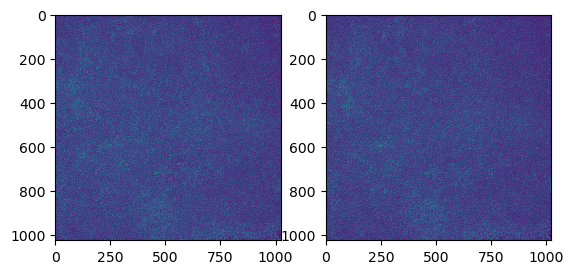

PyObject <matplotlib.image.AxesImage object at 0x000001FD91D1E270>

In [9]:
img1 = DAPT_img[ :, :, 20]
img2 = DAPT_img[ :, :, 21]

subplot( 1, 2, 1 ); PyPlot.imshow(img1)
subplot(1, 2, 2); PyPlot.imshow(img2)

## Do PIV only on two images

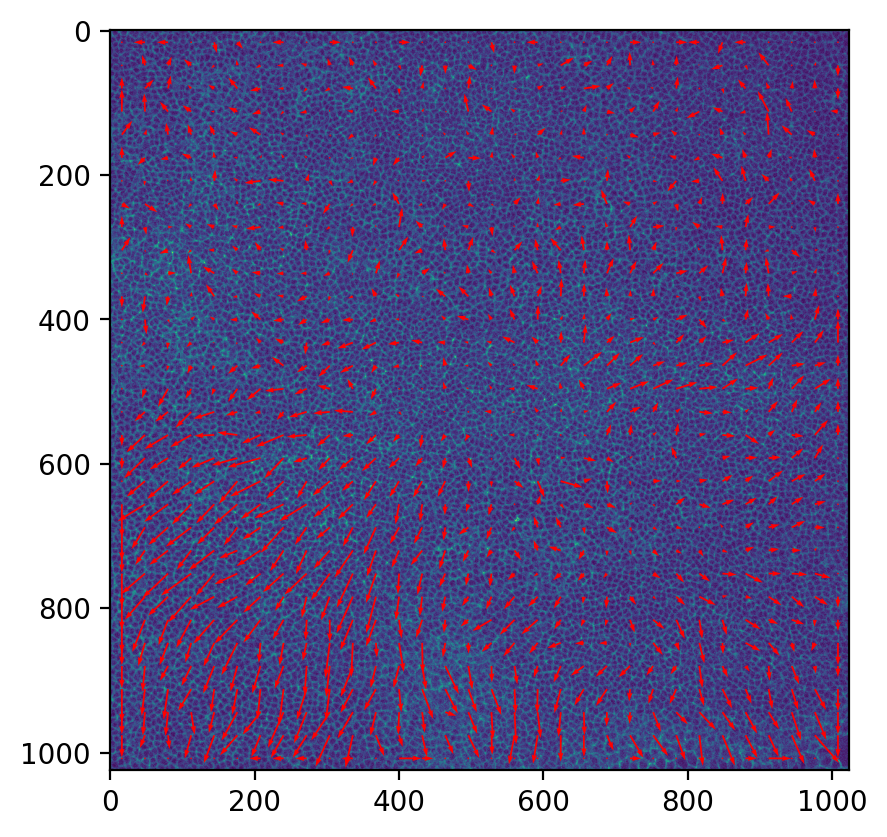

PyObject <matplotlib.quiver.Quiver object at 0x000001FDA3DECB60>

In [10]:
pivparams = multi_quickPIV.setPIVParameters(interSize=(32, 32), searchMargin=(64, 64), step=(32, 32))#, computeSN=true)
VF, _ = multi_quickPIV.PIV( img1, img2, pivparams, precision=16)

IA = multi_quickPIV._isize(pivparams)
ST = multi_quickPIV._step(pivparams)

U = VF[ 1, :, : ]
#U.*= ( SN .> 1.015 )
V = VF[ 2, :, : ]
#V.*= ( SN .> 1.015 )

M = sqrt.( U .^ 2 .+ V .^ 2 ) # Magnitude of the vectors.
U.*= ( M .< 5 )
V.*= ( M .< 5 )
ygrid = [ ( y - 1 )*ST[1] + div( IA[1], 2 ) for y in 1:size(U,1), x in 1:size(U,2) ]
xgrid = [ ( x - 1 )*ST[2] + div( IA[2], 2 ) for y in 1:size(U,1), x in 1:size(U,2) ]

PyPlot.figure( dpi=200 )
PyPlot.imshow( img1)
PyPlot.quiver( xgrid, ygrid, V, -U, color="red")

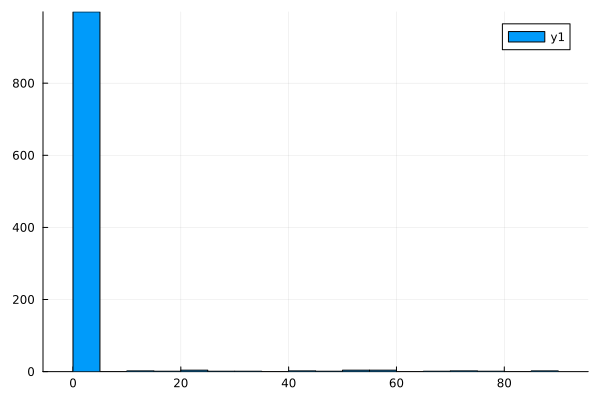

In [27]:
using Plots
histogram(vec(M), bins=20)

## PIV between all two follwing images and over all time points. 
Storing at the end the vector fields as .h5 file. 

In [11]:
function PIV_generation(img_series)
    
    pivparams = multi_quickPIV.setPIVParameters(interSize=(32, 32), searchMargin=(64, 64), step=(32, 32))#, computeSN=true)
    IA = multi_quickPIV._isize(pivparams)
    ST = multi_quickPIV._step(pivparams)
    
    m_U = Matrix{Float32}[]
    m_V = Matrix{Float32}[]
    m_xgrid = Matrix{Float32}[]
    m_ygrid = Matrix{Float32}[]
    m_M = Matrix{Float32}[]
    
    for i in 1:size(img_series, 3)-1 
    
        img1 = img_series[ :, :, i]
        img2 = img_series[ :, :, i+1]
        
        VF, _ = multi_quickPIV.PIV( img1, img2, pivparams, precision=16)
        
        U = VF[ 1, :, : ]
        #U.*= ( SN .> 1.015 )
        V = VF[ 2, :, : ]
        #V.*= ( SN .> 1.015 )
        
        M = sqrt.( U .^ 2 .+ V .^ 2 ) # Magnitude of the vectors. 
        U.*= ( M .< 5 ) # Set filter based on magnitude. 
        V.*= ( M .< 5 )
        ygrid = [ ( y - 1 )*ST[1] + div( IA[1], 2 ) for y in 1:size(U,1), x in 1:size(U,2) ]
        xgrid = [ ( x - 1 )*ST[2] + div( IA[2], 2 ) for y in 1:size(U,1), x in 1:size(U,2) ]
    
        push!(m_U, U)
        push!(m_V, V)
        push!(m_xgrid, xgrid)
        push!(m_ygrid, ygrid)
        push!(m_M, M)
    
        print("tu")
        
    end
    # Converting dimensions with time.
    U_data = reduce((x,y) -> cat(x,y,dims=3), m_U)
    V_data = reduce((x,y) -> cat(x,y,dims=3), m_V)
    xgrid_data = reduce((x,y) -> cat(x,y,dims=3), m_xgrid)
    ygrid_data = reduce((x,y) -> cat(x,y,dims=3), m_ygrid)
    M_data = reduce((x,y) -> cat(x,y,dims=3), m_M)

    return U_data, V_data, xgrid_data, ygrid_data, M_data
end


PIV_generation (generic function with 1 method)

In [12]:
U_data, V_data, xgrid_data, ygrid_data, M_data = PIV_generation(DAPT_img)

tutututututututututututututututututututututututututututututututututututututu

(Float32[2.0 1.058454 … 2.5688715 2.0; 2.0 0.6275293 … 2.470123 2.0044358; … ; 2.0677376 2.4296882 … 1.5561872 1.0; 0.0 -0.0 … -0.0 -0.0;;; 1.0 1.6748556 … 1.8969587 1.0; 2.0 2.1225624 … 2.2371411 2.1384518; … ; 2.0 3.173045 … 1.109129 3.0; -0.0 -0.0 … 0.0 -0.0;;; 2.0 1.3258303 … 1.491406 2.0; 2.0 1.0269433 … 1.9965711 2.0; … ; 3.0 2.6734462 … 0.7899188 2.0; 0.0 -0.0 … 0.0 0.0;;; … ;;; 0.89012873 0.0 … 1.3288363 2.0; 1.0 -0.13465446 … 1.8659359 0.0; … ; 1.3585429 0.81567055 … -0.9823651 0.26354384; 0.0 0.0 … 0.0 0.0;;; 1.0 0.89173204 … 0.99088204 0.0; 1.0 0.35538843 … -0.16652067 0.0; … ; 1.0 0.7908405 … -1.198043 -0.66758275; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 1.0; 0.45475337 -0.034918033 … -0.058805194 0.0; … ; 1.0 -0.14751476 … -1.2049747 -1.0331385; 0.0 0.0 … -0.9905493 -1.8453363], Float32[0.0 -0.247798 … -0.20678715 0.0; 0.0 -0.3326313 … -0.30693862 -0.9790705; … ; 1.3048384 1.3379129 … 0.26144388 0.0; 1.0 0.0 … -0.0 -0.0;;; 0.0 -0.40395236 … -0.17408119 0.0; 0.0 -0.2625932 … -0.

In [13]:
h5open("memGFP_DAPT_PIV.h5", "w") do file
    write(file, "U", U_data)
    write(file, "V", V_data)
    write(file, "xgrid", xgrid_data)
    write(file, "ygrid", ygrid_data)
    write(file, "M", M_data)
end

## Generating PIV with sliding window between frame t0 to frame t1.
Chosen 10 frames as distance for PIV analysation. 

In [9]:
# function sliding_window_PIV(img_series, t0, t1, frame_dist)
    
#     pivparams = multi_quickPIV.setPIVParameters(interSize=(64, 64), searchMargin=(128, 128), step=(64, 64), computeSN=true)
    
#     m_U = Matrix{Float32}[]
#     m_V = Matrix{Float32}[]
#     m_xgrid = Matrix{Float32}[]
#     m_ygrid = Matrix{Float32}[]
#     m_M = Matrix{Float32}[]
    
#     for i in t0:t1 
        
#         img1 = Float16.(img_series[:, :, i])
#         img2 = Float16.(img_series[:, :, i+frame_dist])

#         VF, SN = multi_quickPIV.PIV( img1, img2, pivparams, precision=16)

#         IA = multi_quickPIV._isize(pivparams)
#         ST = multi_quickPIV._step(pivparams)
        
#         U = VF[ 1, :, : ]
#         #U.*= ( SN .> 1.015 )
#         V = VF[ 2, :, : ]
#         #V.*= ( SN .> 1.015 )
        
#         M = sqrt.( U .^ 2 .+ V .^ 2 ) # Magnitude of the vectors.
#         U.*= ( M .< 20 )
#         V.*= ( M .< 20 )
#         ygrid = [ ( y - 1 )*ST[1] + div( IA[1], 2 ) for y in 1:size(U,1), x in 1:size(U,2) ]
#         xgrid = [ ( x - 1 )*ST[2] + div( IA[2], 2 ) for y in 1:size(U,1), x in 1:size(U,2) ]

#         push!(m_U, U)
#         push!(m_V, V)
#         push!(m_xgrid, xgrid)
#         push!(m_ygrid, ygrid)
#         push!(m_M, M)
#         print("tu")
#     end

#     # Converting dimensions with time.
#     U_data = reduce((x,y) -> cat(x,y,dims=3), m_U)
#     V_data = reduce((x,y) -> cat(x,y,dims=3), m_V)
#     xgrid_data = reduce((x,y) -> cat(x,y,dims=3), m_xgrid)
#     ygrid_data = reduce((x,y) -> cat(x,y,dims=3), m_ygrid)
#     M_data = reduce((x,y) -> cat(x,y,dims=3), m_M)
    
#     return U_data, V_data, xgrid_data, ygrid_data, M_data
# end

sliding_window_PIV (generic function with 1 method)

In [29]:
# frame_dist = 10
# m_U, m_V, m_xgrid, m_ygrid, m_M = sliding_window_PIV(red_beads, 1, size(red_beads)[3]-frame_dist, frame_dist)
# m_U

In [11]:
# # Store the data into .h5 file. 
# h5open("U_matrix", "w") do file
#     write(file, "matrix", m_U)
# end

# h5open("V_matrix", "w") do file
#     write(file, "matrix", m_V)
# end

# h5open("M_matrix", "w") do file
#     write(file, "matrix", m_M)
# end

# h5open("xgrid_matrix", "w") do file
#     write(file, "matrix", m_xgrid)
# end

# h5open("ygrid_matrix", "w") do file
#     write(file, "matrix", m_ygrid)
# end